In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.utils import to_networkx
from torchinfo import summary
from tqdm import tqdm

In [2]:
WINDOW_SIZE = 24
WINDOW_STRIDE = 6
LEAD_TIME = 1

NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.005
WEIGHT_DECAY = 5e-4

# TODO add torch.manual_seed(1234567)

In [3]:
class LamaHDataset(Dataset):
    DATA_URL = "https://zenodo.org/record/5153305/files/1_LamaH-CE_daily_hourly.tar.gz"

    def __init__(self, root, years=range(2000, 2018), window_size_hrs=24, window_stride_hrs=1, lead_time_hrs=1,
                 transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)  # calls download() and process() if necessary

        self.window_size_hrs = window_size_hrs
        self.window_stride_hrs = window_stride_hrs
        self.lead_time_hrs = lead_time_hrs
        self.year_sizes = [
            (24 * (365 + int(year % 4 == 0)) - (window_size_hrs + lead_time_hrs)) // window_stride_hrs + 1
            for year in years]

        adjacency = pd.read_csv(self.processed_paths[0])
        gauges = list(sorted(set(adjacency["ID"]).union(adjacency["NEXTDOWNID"])))
        rev_index = {gauge_id: i for i, gauge_id in enumerate(gauges)}
        edge_cols = adjacency[["ID", "NEXTDOWNID"]].applymap(lambda x: rev_index[x])
        self.edge_index = torch.tensor(edge_cols.values.transpose(), dtype=torch.long)
        weight_cols = adjacency[["dist_hdn", "elev_diff", "strm_slope"]]
        self.edge_attr = torch.tensor(weight_cols.values, dtype=torch.float)

        self.year_tensors = [[] for _ in years]
        print("Loading dataset into memory...")
        for gauge_id in tqdm(gauges):
            df = pd.read_csv(f"{self.raw_dir}/{self.raw_file_names[1]}/hourly/ID_{gauge_id}.csv",
                             sep=";", usecols=["YYYY", "qobs"])
            df["qobs"] = (df["qobs"] - df["qobs"].mean()) / df["qobs"].std()
            for i, year in enumerate(years):
                self.year_tensors[i].append(torch.tensor(df[df["YYYY"] == year]["qobs"].values, dtype=torch.float))
        self.year_tensors[:] = map(torch.stack, self.year_tensors)

    @property
    def raw_file_names(self):
        return ["B_basins_intermediate_all/1_attributes", "D_gauges/2_timeseries"]

    @property
    def processed_file_names(self):
        return ["adjacency.csv"]

    def download(self):
        print("Downloading LamaH-CE from Zenodo to", self.raw_dir)
        total_size = int(urllib.request.urlopen(self.DATA_URL).info().get('Content-Length'))
        with tqdm(total=total_size, unit="B", unit_scale=True, unit_divisor=1024) as pbar:
            filename, _ = urllib.request.urlretrieve(self.DATA_URL, reporthook=lambda _, n, __: pbar.update(n))
        with tarfile.open(filename) as archive:
            archive.extractall(self.raw_dir, members=list(
                filter(lambda t: t.name.startswith(tuple(self.raw_file_names)), archive.getmembers())))

    def process(self):
        print(f"Preprocessing LamaH-CE to {self.processed_paths[0]}...")

        stream_dist = pd.read_csv(f"{self.raw_dir}/{self.raw_file_names[0]}/Stream_dist.csv", sep=";")
        stream_dist.drop(columns="strm_slope", inplace=True)  # will re-calculate from dist_hdn and elev_diff

        def collect_upstream(id):
            predecessors = set(stream_dist[stream_dist["NEXTDOWNID"] == id]["ID"])
            if len(predecessors) == 0:
                return {id}
            else:
                return {id}.union(*(collect_upstream(pred) for pred in predecessors))

        connected_gauges = set(stream_dist["ID"]).union(stream_dist["NEXTDOWNID"])
        danube_gauges = set(collect_upstream(399))  # 399 is most downstream Danube gauge, use 373 if more years wanted
        assert danube_gauges.issubset(connected_gauges)

        feasible_gauges = set()
        for gauge_id in tqdm(danube_gauges, desc="Gauge filtering"):
            ts = pd.read_csv(f"{self.raw_dir}/{self.raw_file_names[1]}/hourly/ID_{gauge_id}.csv",
                             sep=";", usecols=["YYYY", "MM", "DD", "hh", "mm", "qobs"])
            if (ts["qobs"] >= 0).all():
                if ts.iloc[0]["YYYY"] <= 2000:
                    sub_ts = ts[ts["YYYY"] >= 2000]
                    if len(sub_ts) == (
                            18 * 365 + 5) * 24:  # 262_992:  # number of hours in 1988-2017, namely (22 * 365 + 8 * 366) * 24
                        feasible_gauges.add(gauge_id)
                        assert tuple(sub_ts.iloc[0, :5]) == (2000, 1, 1, 0, 0) \
                               and tuple(sub_ts.iloc[-1, :5]) == (2017, 12, 31, 23, 0)
        print("Determined", len(feasible_gauges), "feasible gauges.")
        assert 399 in feasible_gauges

        for gauge_id in tqdm(connected_gauges - feasible_gauges, desc="Bad gauge removal"):
            incoming_edges = stream_dist.loc[stream_dist["NEXTDOWNID"] == gauge_id]
            outgoing_edges = stream_dist.loc[stream_dist["ID"] == gauge_id]

            stream_dist.drop(labels=incoming_edges.index, inplace=True)
            stream_dist.drop(labels=outgoing_edges.index, inplace=True)

            bypass = incoming_edges.merge(outgoing_edges, how="cross", suffixes=["", "_"])
            bypass["NEXTDOWNID"] = bypass["NEXTDOWNID_"]
            bypass["dist_hdn"] += bypass["dist_hdn_"]
            bypass["elev_diff"] += bypass["elev_diff_"]
            stream_dist = pd.concat([stream_dist, bypass[["ID", "NEXTDOWNID", "dist_hdn", "elev_diff"]]],
                                    ignore_index=True, copy=False)

            stream_dist.reset_index()

        stream_dist["strm_slope"] = stream_dist["elev_diff"] / stream_dist["dist_hdn"]
        assert feasible_gauges.issubset(danube_gauges)

        print("Saving final adjacency list to disk...")
        stream_dist.to_csv(self.processed_paths[0], index=False)

    def len(self):
        return sum(self.year_sizes)

    def get(self, idx):
        year_tensor, offset = self._decode_index(idx)
        x = year_tensor[:, offset:(offset + self.window_size_hrs)]
        y = year_tensor[:, offset + self.window_size_hrs + (self.lead_time_hrs - 1)]
        return Data(x=x, y=y.unsqueeze(-1), edge_index=self.edge_index, edge_attr=self.edge_attr)

    def _decode_index(self, idx):
        for i, size in enumerate(self.year_sizes):
            idx -= size
            if idx < 0:
                return self.year_tensors[i], self.window_stride_hrs * (idx + size)
        raise AssertionError("This cannot happen!")

In [4]:
train_dataset = LamaHDataset("LamaH-CE",
                             window_size_hrs=WINDOW_SIZE,
                             window_stride_hrs=WINDOW_STRIDE,
                             years=[y for y in range(2000, 2018) if y % 8 != 0])
eval_dataset = LamaHDataset("LamaH-CE",
                            window_size_hrs=WINDOW_SIZE,
                            window_stride_hrs=1,  # TODO later set to 1
                            years=[y for y in range(2000, 2018) if y % 8 == 0])
#test_dataset = LamaHDataset("LamaH-CE",
#                            window_size_hrs=WINDOW_SIZE,
#                            window_stride_hrs=WINDOW_STRIDE,
#                            years=[y for y in range(1988, 2018) if y % 8 == 4])

Loading dataset into memory...


100%|██████████| 375/375 [00:46<00:00,  8.13it/s]


Loading dataset into memory...


100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


#vertices: 375
#edges: 374
#features: 24
directed graph?: True
isolated vertices? False
self-loops? False


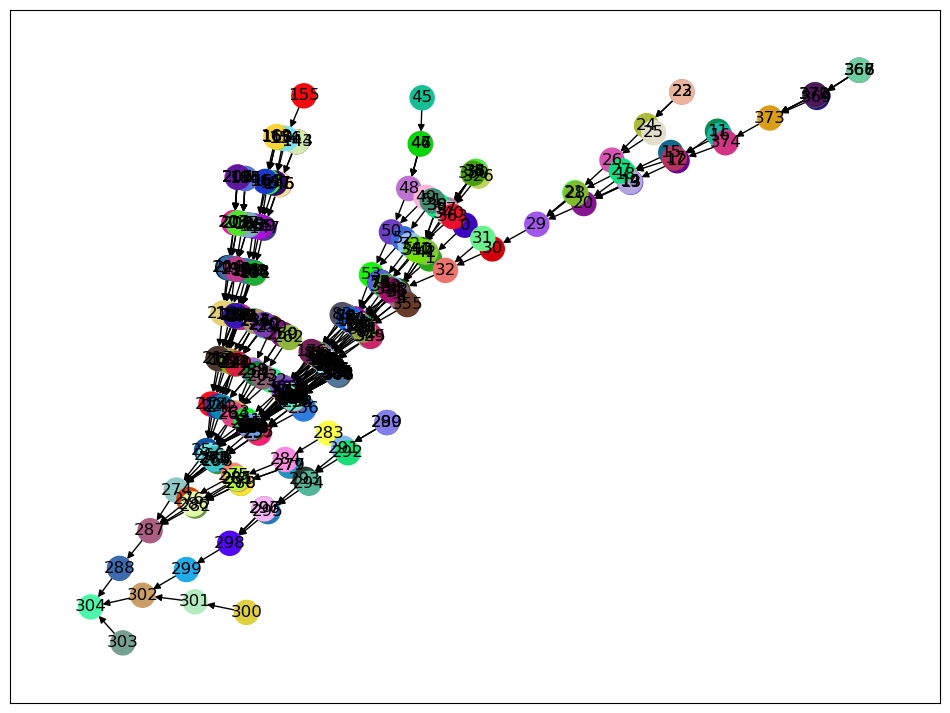

In [5]:
data = eval_dataset[4200]
print("#vertices:", data.num_nodes)
print("#edges:", data.num_edges)
print("#features:", data.num_node_features)
print("directed graph?:", data.is_directed())
print("isolated vertices?", data.has_isolated_nodes())
print("self-loops?", data.has_self_loops())
plt.figure(figsize=(12, 9))
graph = to_networkx(data, to_undirected=False)
nx.draw_networkx(graph, pos=nx.drawing.kamada_kawai_layout(graph), with_labels=True,
                 node_color=[tuple(torch.rand(3)) for _ in range(375)])

In [6]:
def get_edge_weights(weight_type):
    if weight_type == "dist_hdn":
        return data.edge_attr[:, 0]
    elif weight_type == "elev_diff":
        return data.edge_attr[:, 1]
    elif weight_type == "strm_slope":
        return data.edge_attr[:, 2]
    else:
        return torch.ones(data.num_edges)


class MLP(nn.Module):
    def __init__(self, window_size_hrs=24, num_hidden=2, hidden_size=128):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(window_size_hrs, hidden_size) if i == 0 else
                                     nn.Linear(hidden_size, 1) if i == num_hidden else
                                     nn.Linear(hidden_size, hidden_size)
                                     for i in range(0, num_hidden + 1)])

    def forward(self, data):
        x = data.x
        for layer in self.layers[:-1]:
            x = layer(x)
            x = F.relu(x)
        x = self.layers[-1](x)
        return x


class GCN(nn.Module):
    def __init__(self, window_size_hrs=24, num_hidden=2, hidden_size=128, weight_type=None):
        super().__init__()
        self.convs = nn.ModuleList([GCNConv(window_size_hrs, hidden_size) if i == 0 else
                                    GCNConv(hidden_size, hidden_size)
                                    for i in range(num_hidden + 1)])
        self.linear_out = nn.Linear(hidden_size, 1)
        self.weight_type = weight_type

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weights = get_edge_weights(self.weight_type, edge_index).to(data.x.device)

        for conv in self.convs:
            x = conv(x, edge_index, edge_weights)
            x = F.relu(x)
        x = self.linear_out(x)

        return x


class ResGCN(nn.Module):
    def __init__(self, window_size_hrs=24, num_convs=2, hidden_size=128, weight_type=None):
        super().__init__()
        self.linear_in = nn.Linear(window_size_hrs, hidden_size)
        self.linear_out = nn.Linear(hidden_size, 1)
        self.convs = nn.ModuleList(GCNConv(hidden_size, hidden_size) for _ in range(num_convs))
        self.weight_type = weight_type

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weights = torch.cat(data.num_graphs * [get_edge_weights(self.weight_type).to(data.x.device)])

        x = self.linear_in(x)
        for conv in self.convs:
            x = x + conv(x, edge_index, edge_weights)
            x = F.relu(x)
        x = self.linear_out(x)

        return x


class IsolatedGCN(nn.Module):
    def __init__(self, window_size_hrs=24, num_hidden=2, hidden_size=128, weight_type=None):
        super().__init__()
        self.convs = nn.ModuleList([GCNConv(window_size_hrs, hidden_size) if i == 0 else
                                    GCNConv(hidden_size, hidden_size)
                                    for i in range(num_hidden + 1)])
        self.linear_out = nn.Linear(hidden_size, 1)
        self.weight_type = weight_type

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_index = torch.empty((2, 0), dtype=torch.long).to(x.device)


        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = self.linear_out(x)

        return x


class GAT(torch.nn.Module):
    def __init__(self, window_size_hrs=24, num_hidden=2, hidden_size=128):
        super().__init__()
        self.layers = nn.ModuleList([GATConv(window_size_hrs, hidden_size) if i == 0 else
                                     GATConv(hidden_size, 1) if i == num_hidden else
                                     GATConv(hidden_size, hidden_size)
                                     for i in range(0, num_hidden + 1)])

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.elu(x)
        x = self.layers[-1](x, edge_index)

        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
#model = MLP(window_size_hrs=WINDOW_SIZE, num_hidden=4, hidden_size=64).to(device)
model = ResGCN(window_size_hrs=WINDOW_SIZE, num_convs=3, hidden_size=64, weight_type="elev_diff").to(device)
#model = GCN(window_size_hrs=WINDOW_SIZE, num_hidden=3, hidden_size=64).to(device)
#model = IsolatedGCN(window_size_hrs=WINDOW_SIZE).to(device)
#model = GAT(window_size_hrs=WINDOW_SIZE).to(device)
#model = GCN(in_channels=WINDOW_SIZE, hidden_channels=128, out_channels=1, num_layers=3)
#model = MLP(in_channels=WINDOW_SIZE, hidden_channels=128, out_channels=1, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
summary(model)

Device: cpu


Layer (type:depth-idx)                   Param #
ResGCN                                   --
├─Linear: 1-1                            1,600
├─Linear: 1-2                            65
├─ModuleList: 1-3                        --
│    └─GCNConv: 2-1                      64
│    │    └─SumAggregation: 3-1          --
│    │    └─Linear: 3-2                  4,096
│    └─GCNConv: 2-2                      64
│    │    └─SumAggregation: 3-3          --
│    │    └─Linear: 3-4                  4,096
│    └─GCNConv: 2-3                      64
│    │    └─SumAggregation: 3-5          --
│    │    └─Linear: 3-6                  4,096
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0

In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_losses = []
eval_losses = []
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out, batch.y)
        train_loss += loss.item() * batch.num_graphs / len(train_dataset)
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        eval_loss = 0
        for batch in tqdm(eval_loader, desc="Evaluating"):
            batch = batch.to(device)
            out = model(batch)
            loss = F.mse_loss(out, batch.y)
            eval_loss += loss.item() * batch.num_graphs / len(eval_dataset)
        eval_losses.append(eval_loss)

    print(f"Loss (train/eval): {train_losses[-1]:.4f}/{eval_losses[-1]:.4f}")

Epoch 1/50


Evaluating: 100%|██████████| 822/822 [00:31<00:00, 26.34it/s]


Loss (train/eval): 0.6320/0.1099
Epoch 2/50


Evaluating: 100%|██████████| 822/822 [00:28<00:00, 28.51it/s]


Loss (train/eval): 0.1832/0.1327
Epoch 3/50


Evaluating: 100%|██████████| 822/822 [00:28<00:00, 28.36it/s]


Loss (train/eval): 0.0993/0.0596
Epoch 4/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.78it/s]


Loss (train/eval): 0.0899/0.0569
Epoch 5/50


Evaluating: 100%|██████████| 822/822 [00:32<00:00, 25.46it/s]


Loss (train/eval): 0.1058/0.0433
Epoch 6/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.20it/s]


Loss (train/eval): 0.0598/0.0277
Epoch 7/50


Evaluating: 100%|██████████| 822/822 [00:28<00:00, 28.45it/s]


Loss (train/eval): 0.0438/0.0229
Epoch 8/50


Evaluating: 100%|██████████| 822/822 [00:29<00:00, 28.02it/s]


Loss (train/eval): 0.0409/0.0214
Epoch 9/50


Evaluating: 100%|██████████| 822/822 [00:28<00:00, 28.81it/s]


Loss (train/eval): 0.0717/0.0296
Epoch 10/50


Evaluating: 100%|██████████| 822/822 [00:28<00:00, 28.74it/s]


Loss (train/eval): 0.0407/0.0224
Epoch 11/50


Evaluating: 100%|██████████| 822/822 [00:29<00:00, 27.68it/s]


Loss (train/eval): 0.0342/0.0195
Epoch 12/50


Evaluating: 100%|██████████| 822/822 [00:29<00:00, 28.23it/s]


Loss (train/eval): 0.0238/0.0179
Epoch 13/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.38it/s]


Loss (train/eval): 0.0256/0.0197
Epoch 14/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.28it/s]


Loss (train/eval): 0.0232/0.0185
Epoch 15/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.80it/s]


Loss (train/eval): 0.0238/0.0170
Epoch 16/50


Evaluating: 100%|██████████| 822/822 [00:31<00:00, 25.75it/s]


Loss (train/eval): 0.0212/0.0165
Epoch 17/50


Evaluating: 100%|██████████| 822/822 [00:33<00:00, 24.77it/s]


Loss (train/eval): 0.0193/0.0181
Epoch 18/50


Evaluating: 100%|██████████| 822/822 [00:31<00:00, 26.40it/s]


Loss (train/eval): 0.4117/0.1749
Epoch 19/50


Evaluating: 100%|██████████| 822/822 [00:32<00:00, 25.64it/s]


Loss (train/eval): 0.1981/0.1330
Epoch 20/50


Evaluating: 100%|██████████| 822/822 [00:33<00:00, 24.79it/s]


Loss (train/eval): 0.1730/0.5735
Epoch 21/50


Evaluating: 100%|██████████| 822/822 [00:31<00:00, 25.84it/s]


Loss (train/eval): 0.1267/0.0447
Epoch 22/50


Evaluating: 100%|██████████| 822/822 [00:36<00:00, 22.60it/s]


Loss (train/eval): 0.0946/0.0387
Epoch 23/50


Evaluating: 100%|██████████| 822/822 [00:32<00:00, 24.92it/s]


Loss (train/eval): 0.0901/0.0876
Epoch 24/50


Evaluating: 100%|██████████| 822/822 [00:33<00:00, 24.67it/s]


Loss (train/eval): 0.0644/0.0271
Epoch 25/50


Evaluating: 100%|██████████| 822/822 [00:32<00:00, 25.37it/s]


Loss (train/eval): 0.0332/0.0207
Epoch 26/50


Evaluating: 100%|██████████| 822/822 [00:46<00:00, 17.57it/s]


Loss (train/eval): 0.0255/0.0206
Epoch 27/50


Evaluating: 100%|██████████| 822/822 [00:35<00:00, 22.98it/s]


Loss (train/eval): 0.0267/0.0525
Epoch 28/50


Evaluating: 100%|██████████| 822/822 [00:32<00:00, 25.07it/s]


Loss (train/eval): 0.0269/0.0290
Epoch 29/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.84it/s]


Loss (train/eval): 0.0280/0.0181
Epoch 30/50


Evaluating: 100%|██████████| 822/822 [00:29<00:00, 27.47it/s]


Loss (train/eval): 0.0215/0.0208
Epoch 31/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.04it/s]


Loss (train/eval): 0.0858/0.0195
Epoch 32/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.38it/s]


Loss (train/eval): 0.0246/0.0260
Epoch 33/50


Evaluating: 100%|██████████| 822/822 [00:55<00:00, 14.93it/s]


Loss (train/eval): 0.0208/0.0183
Epoch 34/50


Evaluating: 100%|██████████| 822/822 [00:50<00:00, 16.20it/s]


Loss (train/eval): 0.0193/0.0161
Epoch 35/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 27.24it/s]


Loss (train/eval): 0.5149/0.1475
Epoch 36/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.84it/s]


Loss (train/eval): 0.2013/0.1193
Epoch 37/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.72it/s]


Loss (train/eval): 0.1362/0.0529
Epoch 38/50


Evaluating: 100%|██████████| 822/822 [00:30<00:00, 26.66it/s]


Loss (train/eval): 0.0531/0.0685
Epoch 39/50


Evaluating: 100%|██████████| 822/822 [00:44<00:00, 18.51it/s]


Loss (train/eval): 0.0433/0.0530
Epoch 40/50


Evaluating: 100%|██████████| 822/822 [00:46<00:00, 17.55it/s]


Loss (train/eval): 0.0468/0.0213
Epoch 41/50


Evaluating: 100%|██████████| 822/822 [00:52<00:00, 15.70it/s]


Loss (train/eval): 0.0285/0.0173
Epoch 42/50


Evaluating: 100%|██████████| 822/822 [01:07<00:00, 12.20it/s]


Loss (train/eval): 0.0219/0.0187
Epoch 43/50


Evaluating: 100%|██████████| 822/822 [00:33<00:00, 24.71it/s]


Loss (train/eval): 0.2986/0.3481
Epoch 44/50


Evaluating: 100%|██████████| 822/822 [00:31<00:00, 25.81it/s]


Loss (train/eval): 0.2018/0.0662
Epoch 45/50


Evaluating: 100%|██████████| 822/822 [00:34<00:00, 23.76it/s]


Loss (train/eval): 0.0707/0.0395
Epoch 46/50


Evaluating: 100%|██████████| 822/822 [01:08<00:00, 11.94it/s]


Loss (train/eval): 0.0775/0.0294
Epoch 47/50


Evaluating: 100%|██████████| 822/822 [01:17<00:00, 10.63it/s]


Loss (train/eval): 0.0300/0.0182
Epoch 48/50


Evaluating: 100%|██████████| 822/822 [01:51<00:00,  7.38it/s]


Loss (train/eval): 0.0298/0.0220
Epoch 49/50


Evaluating: 100%|██████████| 822/822 [01:51<00:00,  7.40it/s]


Loss (train/eval): 0.0257/0.0183
Epoch 50/50


Evaluating: 100%|██████████| 822/822 [01:49<00:00,  7.54it/s]

Loss (train/eval): 0.0202/0.0168


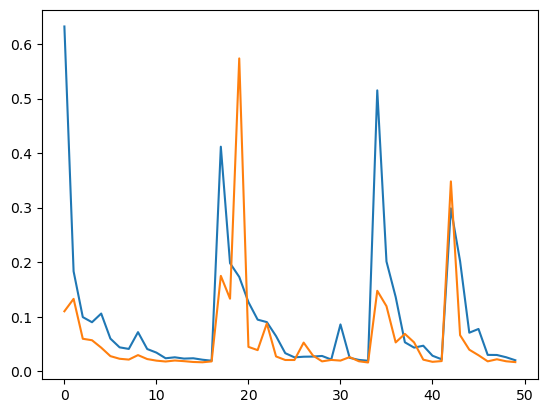

In [9]:
plt.plot(train_losses)
plt.plot(eval_losses)

In [10]:
i = train_losses.index(min(train_losses))
print(f"{train_losses[i]:.4f}/{eval_losses[i]:.4f}")

0.0193/0.0161
